In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import nltk
import time
from sklearn.model_selection import train_test_split

start = time.time()

data_dir = './input'
train = data_dir + '/train.csv'
test = data_dir + '/test.csv'

# sub_df = pd.read_csv(sample)
test_df = pd.read_csv(test)
raw_df = pd.read_csv(train)
df_size = len(raw_df)

SAMPLE_SIZE = int(df_size * 0.01)
sample_df = raw_df.sample(SAMPLE_SIZE, random_state=42)
sentences = sample_df.question_text
labels = np.array(sample_df.target)

nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(sentence):
    return [word for word in sentence if word not in stop_words]

# usuwanie stop words z naszych danych
sentences = [remove_stop_words(sentence) for sentence in sentences]

# tokenizacja danych
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = np.array(tokenizer.texts_to_sequences(sentences))

# zerowanie długości sekwencji do maksymalnej długości
max_length = max([len(seq) for seq in sequences])
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
vocab_size = len(tokenizer.word_index) + 1

# stratify
train_inputs, val_inputs, train_targets, val_targets = train_test_split(padded_sequences
                                                                        , labels
                                                                        , test_size=0.5
                                                                        , random_state=42)
test_inputs, val_inputs, test_targets, val_targets = train_test_split(val_inputs
                                                                      , val_targets
                                                                      , test_size=0.5
                                                                      , random_state=42)


model = keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_inputs, train_targets, epochs=3)

val_loss, val_accuracy = model.evaluate(val_inputs, val_targets)
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.4f}".format(val_accuracy))

print("--- %s seconds ---" % (time.time() - start))

[nltk_data] Downloading package punkt to /Users/kkepins-
[nltk_data]     macwro_1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kkepins-
[nltk_data]     macwro_1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/r3/hdngxsmd2vq391vqv6kg6f7w0000gq/T/ipykernel_5708/86740583.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(tokenizer.texts_to_sequences(sentences))
2023-02-13 16:24:28.693158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-13 16:24:28.693301: I tensorflow/core/common_run

Metal device set to: Apple M1
Epoch 1/3


2023-02-13 16:24:29.752107: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-13 16:24:31.464877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:24:31.660055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:24:31.677278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:24:33.545309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:24:33.562962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


205/205 [==============================] - 30s 121ms/step - loss: 0.2506 - accuracy: 0.9397
Epoch 2/3
205/205 [==============================] - 24s 116ms/step - loss: 0.2298 - accuracy: 0.9397
Epoch 3/3
205/205 [==============================] - 21s 104ms/step - loss: 0.2288 - accuracy: 0.9397


2023-02-13 16:25:46.229878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:25:46.358384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:25:46.369879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 8s 60ms/step - loss: 0.2515 - accuracy: 0.9302
Validation Loss: 0.2515
Validation Accuracy: 0.9302
--- 87.8032591342926 seconds ---


2023-02-13 16:26:25.867283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:26:25.952292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-13 16:26:25.969879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 9s 69ms/step


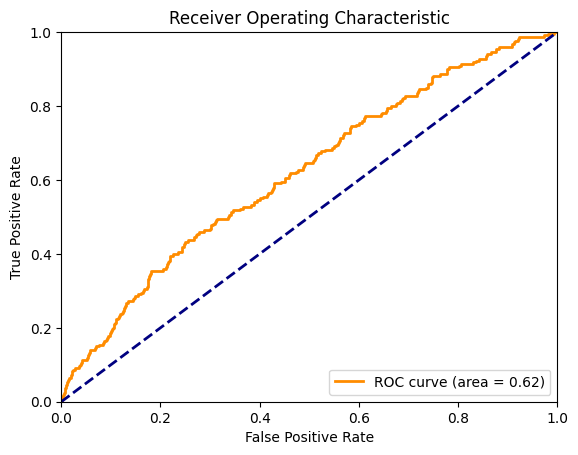

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

test_pred = model.predict(test_inputs)

# false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(test_targets, test_pred)

# ROC (AUC)
roc_auc = auc(fpr, tpr)

# narysuj wykres ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()